# Check relation commutation

In [1]:
%matplotlib inline

import numpy as np
import networkx as nx

from tqdm.notebook import tqdm

from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qrao.encoding import QuantumRandomAccessEncoding, EncodingCommutationVerifier

## Toy maxcut problem

### Uniform weights, degree 2 terms

Note that the variable embedding has some qubits with 1, 2, and 3 qubits

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: maxcut

Maximize
 obj: 40 x0 + 46 x1 + 82 x2 + 88 x3 + 178 x4 + 94 x5 + [ - 24 x0*x1 - 40 x0*x3
      - 96 x0*x5 - 64 x1*x2 - 96 x1*x4 - 120 x2*x3 - 144 x2*x4 - 192 x3*x4
      - 280 x4*x5 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1

Binaries
 x0 x1 x2 x3 x4 x5
End



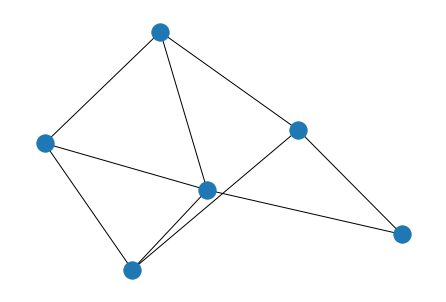

In [2]:
num_nodes = 6
elist = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0), (0, 3), (1, 4), (2, 4)]
edges = np.zeros((num_nodes, num_nodes))
for i, j in elist:
    edges[i, j] = (i + 1) * (j + 2)

mod = Model("maxcut")
nodes = list(range(num_nodes))
var = [mod.binary_var(name="x" + str(i)) for i in nodes]
mod.maximize(
    mod.sum(
        edges[i, j] * (1 - (2 * var[i] - 1) * (2 * var[j] - 1))
        for i in nodes
        for j in nodes
    )
)
graph = nx.from_edgelist(elist)
nx.draw(graph)
problem = from_docplex_mp(mod)
print(problem)

In [3]:
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
encoding.encode(problem)

In [4]:
encoded_problem = encoding.qubit_op  # H
print("Encoded Problem:\n=================")
print(encoded_problem)
print("Offset = ", encoding.offset)
print("{qubit : dvars} = ", encoding.q2vars)

Encoded Problem:
8.999999999999998 * XXI
+ 14.999999999999998 * XYI
+ 35.99999999999999 * XZI
+ 23.999999999999996 * IXX
+ 35.99999999999999 * YXI
+ 44.99999999999999 * IYX
+ 53.99999999999999 * YIX
+ 71.99999999999999 * YYI
+ 104.99999999999999 * YZI
Offset =  -132.0
{qubit : dvars} =  [[0, 4], [1, 3, 5], [2]]


In [5]:
verifier = EncodingCommutationVerifier(encoding)
progress_bar = tqdm(verifier)
for str_dvars, obj_val, encoded_obj_val in progress_bar:
    if not np.isclose(obj_val, encoded_obj_val):
        progress_bar.disp(bar_style="danger")

  0%|          | 0/64 [00:00<?, ?it/s]